### Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Read Data

In [3]:
import torch
import numpy as np
from rdkit import Chem
import rdkit

bond_type_set = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC, 'head']
def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom,
                explicit_H=True,
                use_chirality=False):

    results = one_of_k_encoding_unk(
        atom.GetSymbol(),
        ['C','N','O', 'S','F','Si','P', 'Cl','Br','Mg','Na','Ca','Fe','As','Al','I','B','V','K','Tl',
            'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H', 'Li','Ge','Cu','Au','Ni','Cd','In',
            'Mn','Zr','Cr','Pt','Hg','Pb','Unknown'
        ]) + [atom.GetDegree()/10, atom.GetImplicitValence(), 
                atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
                ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if explicit_H:
        results = results + [atom.GetTotalNumHs()]

    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    results = np.array(results).astype(np.float32)

    return torch.from_numpy(results) # torch.rand_like()

def get_mol_edge_list_and_feat_mtx(mol_graph):
    n_features = [(atom.GetIdx(), atom_features(atom)) for atom in mol_graph.GetAtoms()]
    n_features.sort() # to make sure that the feature matrix is aligned according to the idx of the atom
    _, n_features = zip(*n_features)
    n_features = torch.stack(n_features)
    
    # atm_num = len(n_features)
    # average_row = torch.mean(n_features, dim=0)
    # # random like average_row
    # average_row = torch.rand_like(average_row)
    # # Expand dimensions to match the shape of n_features
    # average_row = torch.unsqueeze(average_row, 0)
    # # Concatenate the average row with n_features
    # n_features_with_head = torch.cat((n_features, average_row), dim=0)
    
    edge_list = torch.LongTensor([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol_graph.GetBonds()])
    edge_attr = torch.FloatTensor([one_of_k_encoding_unk(b.GetBondType(), bond_type_set) for b in mol_graph.GetBonds()])

    # head_edges = torch.LongTensor([(atm_num, i) for i in range(atm_num)])
    # edge_attr_head_edges = torch.FloatTensor([one_of_k_encoding_unk('head', bond_type_set) for i in range(atm_num)])

    # undirected_head_edges = torch.cat([head_edges, head_edges[:, [1, 0]]], dim=0) if len(head_edges) else head_edges
    # undirected_edge_attr_head_edges = torch.cat([edge_attr_head_edges, edge_attr_head_edges], dim=0) if len(edge_attr_head_edges) else edge_attr_head_edges

    undirected_edge_list = torch.cat([edge_list, edge_list[:, [1, 0]]], dim=0) if len(edge_list) else edge_list 
    undirected_edge_attr = torch.cat([edge_attr, edge_attr], dim=0) if len(edge_attr) else edge_attr

    # undirected_edge_list_all = torch.cat([undirected_edge_list, undirected_head_edges], dim=0) if len(undirected_head_edges) else undirected_edge_list
    # undirected_edge_attr_all = torch.cat([undirected_edge_attr, undirected_edge_attr_head_edges], dim=0) if len(undirected_edge_attr_head_edges) else undirected_edge_attr

    return undirected_edge_list.T, n_features, undirected_edge_attr


### Draw Particular Molecule

In [4]:
edge_index,n_features,edge_attr = get_mol_edge_list_and_feat_mtx(mol)
from torch_geometric.data import Data, Batch
mm = Data(x=n_features, edge_index=edge_index, edge_attr=edge_attr)

NameError: name 'mol' is not defined

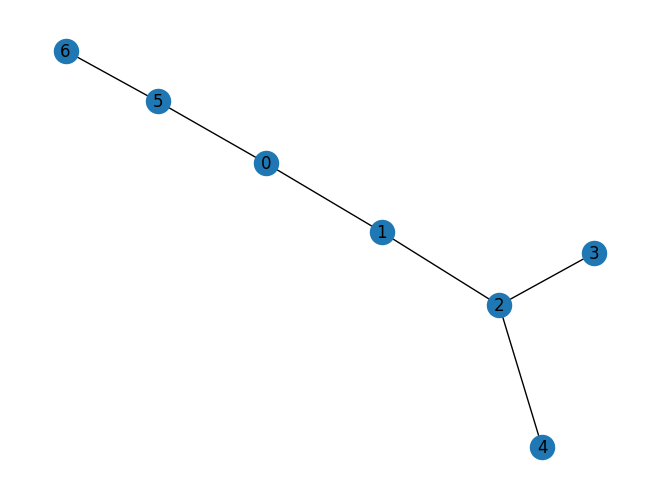

In [11]:
# draw mm molecule graph
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
G = to_networkx(mm, to_undirected=True)
nx.draw(G, with_labels=True)
plt.show()


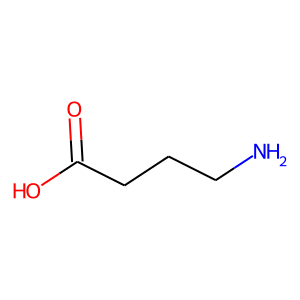

In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.data import Data, Batch

# Define the SMILES string
smiles = "C(CC(=O)O)CN"

# Create an RDKit molecule object from the SMILES string
mol = Chem.MolFromSmiles(smiles)

# Generate a 2D depiction of the molecule
img = Draw.MolToImage(mol)

# Display the image
img.show()


### Read Data Continue

In [5]:
drug_atc_df = pd.read_csv('../../raw_data/sider/drug_atc.tsv', sep='\t', header=None).rename(columns={0:'drug_id', 1:'atc_code'})

In [6]:
drug_atc_df.head()

,drug_id,atc_code
0,CID100000085,A16AA01
1,CID100000119,L03AA03
2,CID100000119,N03AG03
3,CID100000137,L01XD04
4,CID100000143,V03AF03


In [7]:
drug_all_se_df = pd.read_csv('../../raw_data/sider/meddra_all_se.tsv', sep='\t', header=None).rename(columns={0:'STITCH ID FLAT', 
                                                                                                        1:'STITCH ID STEREO',
                                                                                                        2:'UMLS CONCEPT ID',
                                                                                                        3:'MEDDRA CONCEPT TYPE',
                                                                                                        4:'MEDRA TERM UMLS CONCEPT ID',
                                                                                                        5:'SIDE EFFECT NAME'
                                                                                                        })

In [8]:
drug_all_se_df.head()

,STITCH ID FLAT,STITCH ID STEREO,UMLS CONCEPT ID,MEDDRA CONCEPT TYPE,MEDRA TERM UMLS CONCEPT ID,SIDE EFFECT NAME
0,CID100000085,CID000010917,C0000729,LLT,C0000729,Abdominal cramps
1,CID100000085,CID000010917,C0000729,PT,C0000737,Abdominal pain
2,CID100000085,CID000010917,C0000737,LLT,C0000737,Abdominal pain
3,CID100000085,CID000010917,C0000737,PT,C0687713,Gastrointestinal pain
4,CID100000085,CID000010917,C0000737,PT,C0000737,Abdominal pain


In [9]:
# row count where col stitch id flat is same as stitch id stereo
print(drug_all_se_df[drug_all_se_df['STITCH ID FLAT'] == drug_all_se_df['STITCH ID STEREO']].shape)
# filter where MEDDRA concept type is PT
print(drug_all_se_df.shape)

(0, 6)
(309849, 6)


#### Custom Selection of Drugs (with no less 5 or more than 400) and Side-effects with min freq 5

In [10]:
min_freq = 5
max_freq = 400

In [11]:
# keep only PT terms with min freq 5
print(f'Original All_SE {drug_all_se_df.shape}')
drug_all_se_study_df = drug_all_se_df[drug_all_se_df['MEDDRA CONCEPT TYPE'] == 'PT']
print(f'Only PT {drug_all_se_study_df.shape}')
print(f'Unique SE PT {drug_all_se_study_df["MEDRA TERM UMLS CONCEPT ID"].nunique()}')
# drug_all_se_study_df.head()
# keep only meddra concept type with freq > 5
concept_counts = drug_all_se_study_df['MEDRA TERM UMLS CONCEPT ID'].value_counts()
# Filter the DataFrame to keep only concept types with frequency > 5
filtered_df = drug_all_se_study_df[drug_all_se_study_df['MEDRA TERM UMLS CONCEPT ID'].isin(concept_counts[concept_counts >= min_freq].index)]
print(f'PT with freq >{min_freq} {filtered_df.shape}')
print(filtered_df.head())
print(f'Unique PT with freq >{min_freq} {filtered_df["MEDRA TERM UMLS CONCEPT ID"].nunique()}')

Original All_SE (309849, 6)
Only PT (163206, 6)
Unique SE PT 4251
PT with freq >5 (159235, 6)
  STITCH ID FLAT STITCH ID STEREO UMLS CONCEPT ID MEDDRA CONCEPT TYPE  \
1   CID100000085     CID000010917        C0000729                  PT   
3   CID100000085     CID000010917        C0000737                  PT   
4   CID100000085     CID000010917        C0000737                  PT   
6   CID100000085     CID000010917        C0002418                  PT   
8   CID100000085     CID000010917        C0002871                  PT   

  MEDRA TERM UMLS CONCEPT ID       SIDE EFFECT NAME  
1                   C0000737         Abdominal pain  
3                   C0687713  Gastrointestinal pain  
4                   C0000737         Abdominal pain  
6                   C0002418              Amblyopia  
8                   C0002871                Anaemia  
Unique PT with freq >5 2061


the side–effect occurrences and we decided to filter out ADRs
with less than 5 occurrences in the dataset. Through these procedures, we
went from having almost 309,000 associations to about 159,000 associations

#### Drug to list of side-effect

In [12]:
# group by medra term umls concept id and list all side effects name/medra term umls concept id
drug_se_list_df = filtered_df.groupby('STITCH ID STEREO')['MEDRA TERM UMLS CONCEPT ID'].apply(set).apply(list).reset_index()
# Calculate the length of each list
drug_se_list_df['se_count'] = drug_se_list_df['MEDRA TERM UMLS CONCEPT ID'].apply(len)

In [13]:
drug_se_list_df.shape

(1555, 3)

In [14]:
drug_se_list_df.head()

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count
0,CID000000119,"[C0002792, C0030193, C0151828, C0002994, C0042...",5
1,CID000000137,"[C0406834, C0027497, C0019080, C0267792, C0311...",79
2,CID000000143,"[C0011991, C0038362, C0027497, C0002792, C0015...",32
3,CID000000175,"[C0018965, C0020488, C0001122, C0030193]",4
4,CID000000187,"[C0010038, C0010037, C0428977, C0020458, C0020...",7


In [15]:
drug_se_list_df['se_count'].describe()

count    1555.000000
mean       95.702894
std        93.267011
min         1.000000
25%        32.000000
50%        66.000000
75%       127.000000
max       709.000000
Name: se_count, dtype: float64

Text(0.5, 1.0, 'Histogram of Number of Side Effects per Drug')

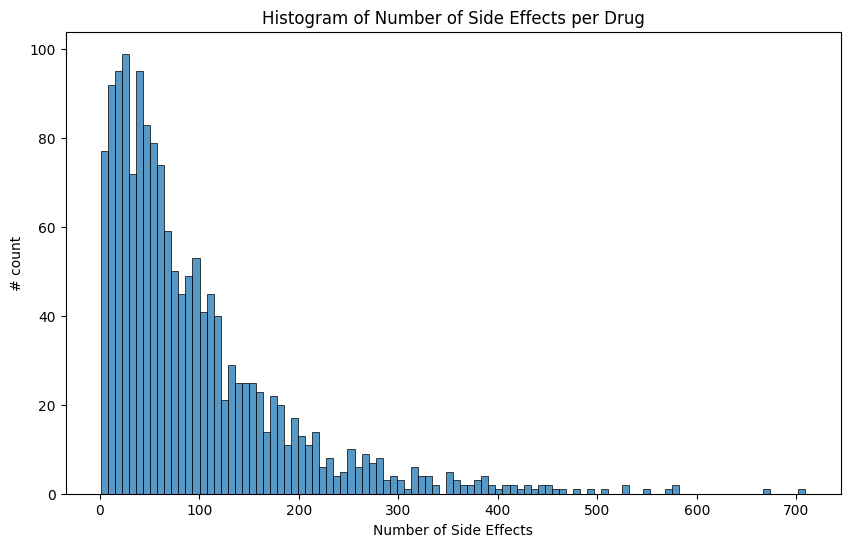

In [26]:
# histograma of se_count and label the x and y axis
plt.figure(figsize=(10, 6))
sns.histplot(data=drug_se_list_df, x='se_count', bins=100)
plt.xlabel('Number of Side Effects')
plt.ylabel('# count')
plt.title('Histogram of Number of Side Effects per Drug')

In [24]:
print(drug_se_list_df.shape)
drug_se_list_df_final = drug_se_list_df[(drug_se_list_df['se_count'] >= 5) & (drug_se_list_df['se_count'] < 400)]
print(drug_se_list_df_final.shape)

(1555, 3)
(1499, 3)


#### Dump prep data

In [18]:
drug_se_list_df.to_csv('../../prep_data/drug_all_se.csv', index=False)
drug_se_list_df_final.to_csv('../../prep_data/drug_all_se_final.csv', index=False)

In [25]:
filtered_df['MEDRA TERM UMLS CONCEPT ID']

1         C0000737
3         C0687713
4         C0000737
6         C0002418
8         C0002871
            ...   
309842    C0242184
309843    C3203358
309844    C1145670
309846    C3665347
309848    C0347390
Name: MEDRA TERM UMLS CONCEPT ID, Length: 159235, dtype: object

Text(0, 0.5, '# Count')

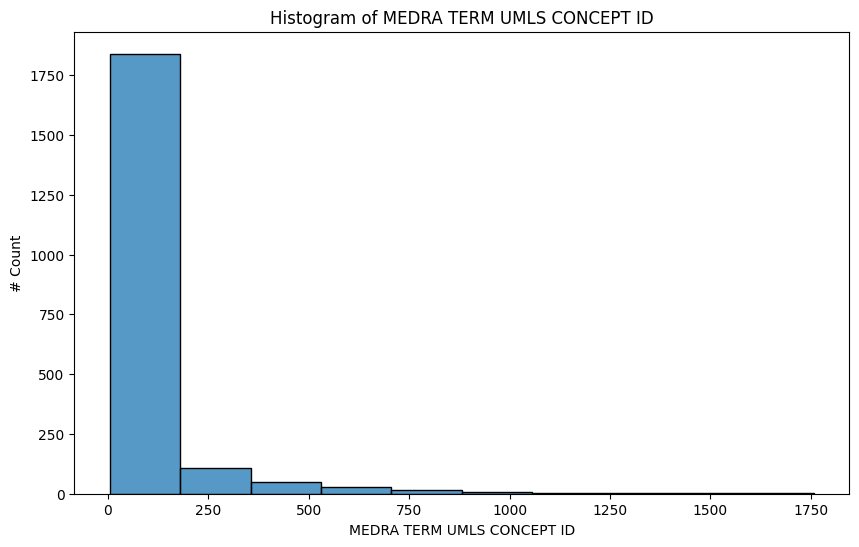

In [28]:
# plot the histogram of value_counts stored in meddra_count
meddra_count = filtered_df['MEDRA TERM UMLS CONCEPT ID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(data=meddra_count, x=meddra_count.values, bins=10)
plt.title('Histogram of MEDRA TERM UMLS CONCEPT ID')
plt.xlabel('MEDRA TERM UMLS CONCEPT ID')
plt.ylabel('# Count')

# plot a bar graph to get each class distributuion too

In [17]:
# - Adverse side effect vs adverse drug
# - selfie include


### Link data

#### STITCH ID to Pubchem_compound_list

In [29]:
drug_se_list_df.head()

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count
0,CID000000119,"[C0002792, C0030193, C0151828, C0002994, C0042...",5
1,CID000000137,"[C0406834, C0027497, C0019080, C0267792, C0311...",79
2,CID000000143,"[C0011991, C0038362, C0027497, C0002792, C0015...",32
3,CID000000175,"[C0018965, C0020488, C0001122, C0030193]",4
4,CID000000187,"[C0010038, C0010037, C0428977, C0020458, C0020...",7


In [19]:
# def stitch_flat_to_pubchem(cid):
#     assert cid.startswith('CID')
#     return int(cid[3:]) - 1e8

# def stitch_stereo_to_pubchem(cid):
#     assert cid.startswith('CID')
#     return int(cid[3:])

In [30]:
drug_se_list_df['cid'] = drug_se_list_df['STITCH ID STEREO'].apply(lambda x: x[4:].lstrip('0')).astype(int)

#### Read Pubchem Data

In [31]:
pubchem_prop_df = pd.read_csv('../../raw_data/pubchem/PubChem_compound_list.csv') # version latest but check

In [32]:
drug_se_list_pubchem_df = drug_se_list_df.merge(pubchem_prop_df, left_on='cid', right_on='cid', how='inner')

In [33]:
print(f'Shape of SIDER before pubmed merge {drug_se_list_df.shape}')
print(f'Shape of SIDER after pubmed merge {drug_se_list_pubchem_df.shape}')

Shape of SIDER before pubmed merge (1555, 4)
Shape of SIDER after pubmed merge (1326, 43)


In [34]:
1555 - 1326

229

In [35]:
drug_se_list_pubchem_df.head(2)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"[C0002792, C0030193, C0151828, C0002994, C0042...",5,119,Gamma-Aminobutyric Acid,4-aminobutyric acid|4-Aminobutanoic acid|GABA|...,103.12,C4H9NO2,63.3,62.7,...,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."
1,CID000000137,"[C0406834, C0027497, C0019080, C0267792, C0311...",79,137,Aminolevulinic acid,5-Aminolevulinic acid|Aminolevulinic acid|106-...,131.13,C5H9NO3,80.4,121.0,...,4919,2D+3D,Aminolevulinic Acid,Biological Test Results|Chemical and Physical ...,14,1511|1554|1662|1663|1672|1813|1814|1832|1850|1...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [36]:
na_count = drug_se_list_pubchem_df.isna().sum()
na_count[na_count > 0]

cmpdname           1
xlogp            212
iupacname          1
neighbortype       1
meshheadings     411
aids             107
annotation      1030
dtype: int64

In [37]:
drug_se_list_pubchem_df.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [38]:
keep_cols = ['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation']

In [14]:
# best alternate way to fetch pubchem data
# import pubchempy as pcp

# stereo_id = "4114" # DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1
# # DB00553,COC1=C2OC(=O)C=CC2=CC2=C1OC=C2,CID000004114
# # DB06261,[H]N([H])CC(=O)CCC(=O)OCCCCCC,CID106433082
# # Convert STITCH ID to CID
# compound = pcp.Compound.from_cid(stereo_id)
# print('Compound Name:', compound.iupac_name)
# print('Molecular Formula:', compound.molecular_formula)
# print('Molecular Weight:', compound.molecular_weight)

Compound Name: 9-methoxyfuro[3,2-g]chromen-7-one
Molecular Formula: C12H8O4
Molecular Weight: 216.19


In [39]:
drug_se_list_pubchem_df[keep_cols].to_csv('../../prep_data/drug_all_se_pubchem.csv', index=False)

#### Link using file from https://github.com/iit-Demokritos/drug_id_mapping

In [42]:
drug_map_df = pd.read_csv('../../raw_data/git_drug_id_mapping/drug_mappings.tsv', sep='\t')

In [43]:
drug_map_df = drug_map_df.dropna(subset=['stitch_id'])

In [44]:
drug_map_df.head()

,drugbankId,name,ttd_id,pubchem_cid,cas_num,chembl_id,zinc_id,chebi_id,kegg_cid,kegg_id,bindingDB_id,UMLS_cuis,stitch_id
57,DB01101,Capecitabine,D00HCQ,60953.0,154361-50-9,CHEMBL1773,ZINC000003806413,31348,C12650,D01223,NaN,C0671970,CID000060953
60,DB01100,Pimozide,D00KHM,16362.0,2062-78-4,CHEMBL1423,ZINC000004175630,8212,C07566,D00560,50334150.0,C0031935,CID000016362
66,DB01105,Sibutramine,D08KVZ,5210.0,106650-56-0,CHEMBL1419,NaN,9137,C07247,D08513,84742.0,C0074493,CID000005210
69,DB01104,Sertraline,D0K0TC,68617.0,79617-96-2,CHEMBL809,ZINC000001853550,9123,C07246,D02360,79021.0,C0074393,CID100005203
77,DB01109,Heparin,D01ZJK,8784.0,9005-49-6,CHEMBL1909300,NaN,28304,C00374,NaN,NaN,C0019134,CID153477714


In [45]:
len(list(set(drug_se_list_df_final['STITCH ID STEREO'].tolist()) - set(drug_map_df['stitch_id'].tolist())))

542

Better to link using the reviou sversion leading to a drop in a simple 2xx numbers